In [92]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os

import pandas as pd
from utils import * 
from PIL import Image
import cv2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [93]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './Private_dataset/'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=2)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
len(class_names)

Train dataset size: 42
Test dataset size: 15


3

In [94]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3) # multi-class classification (num_of_class == 307)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [100]:
num_epochs = 10
start_time = time.time()

train_history = pd.DataFrame(columns=['epoch', 'train_loss', 'train_acc', 'test_loss', 'test_acc'])

for epoch in range(num_epochs):
    """ Training Phase """
    model.train()

    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    train_loss = running_loss / len(train_dataset)
    train_acc = running_corrects.item() / len(train_dataset)

    print('[Train #{}] Loss: {:.4f} Acc: {:.4f} Time: {:.4f}s'.format(epoch, train_loss, train_acc, time.time() - start_time))

    """ Test Phase """
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        test_loss = running_loss / len(test_dataset)
        test_acc = running_corrects.item() / len(test_dataset)
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f} Time: {:.4f}s'.format(epoch, test_loss, test_acc, time.time() - start_time))
        
        train_history = pd.concat([train_history, pd.DataFrame([[epoch, train_loss, train_acc, test_loss, test_acc]], columns=['epoch', 'train_loss', 'train_acc', 'test_loss', 'test_acc'])], ignore_index=True)
# save the model

torch.save(model.state_dict(), 'models/model_3.pth')

# save the training history
train_history.to_csv('history/train_history_3.csv', index=False)


[Train #0] Loss: 0.0131 Acc: 1.0000 Time: 7.9575s
[Test #0] Loss: 0.4083 Acc: 0.7333 Time: 10.5062s
[Train #1] Loss: 0.0051 Acc: 1.0000 Time: 18.4353s
[Test #1] Loss: 0.3836 Acc: 0.7333 Time: 21.1197s
[Train #2] Loss: 0.0059 Acc: 1.0000 Time: 28.9005s
[Test #2] Loss: 0.3485 Acc: 0.7333 Time: 31.4931s
[Train #3] Loss: 0.0029 Acc: 1.0000 Time: 39.0698s
[Test #3] Loss: 0.3124 Acc: 0.7333 Time: 41.7542s
[Train #4] Loss: 0.0017 Acc: 1.0000 Time: 49.3191s
[Test #4] Loss: 0.2818 Acc: 0.7333 Time: 51.9830s
[Train #5] Loss: 0.0010 Acc: 1.0000 Time: 59.6016s
[Test #5] Loss: 0.2578 Acc: 0.8667 Time: 62.2841s
[Train #6] Loss: 0.0006 Acc: 1.0000 Time: 69.8139s
[Test #6] Loss: 0.2342 Acc: 0.8667 Time: 72.5305s
[Train #7] Loss: 0.0004 Acc: 1.0000 Time: 80.3425s
[Test #7] Loss: 0.2113 Acc: 0.9333 Time: 82.9986s
[Train #8] Loss: 0.0003 Acc: 1.0000 Time: 90.6202s
[Test #8] Loss: 0.1937 Acc: 0.9333 Time: 93.2265s
[Train #9] Loss: 0.0002 Acc: 1.0000 Time: 100.8041s
[Test #9] Loss: 0.1740 Acc: 0.9333 Time:

In [21]:
def pgd(model, X, y, epsilon, alpha, num_iter):

    delta = torch.rand_like(X, requires_grad=True)
    #set delta to be in the range of perturbation
    delta.data = delta.data * 2 * epsilon - epsilon

    for t in range(num_iter):
        
        yd = model(X + delta)
        loss = nn.CrossEntropyLoss()(yd, y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()

        
    return delta.detach()


def pgd_target(model, X, y_target, epsilon, alpha, num_iter):

    delta = torch.rand_like(X, requires_grad=True)
    #set delta to be in the range of perturbation
    delta.data = delta.data * 2 * epsilon - epsilon

    #get fake labels as second highest probability
    #y_fake = torch.argsort(model(X), dim=1)[:, -2]

    for t in range(num_iter):

        yd = model(X + delta)
        loss = nn.CrossEntropyLoss()(yd, y_target)
        loss.backward()
        delta.data = (delta - alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
        
    return delta.detach()

In [109]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 15})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()



In [145]:
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(10,10))
    for i in range(M):
        for j in range(N):
            input = X[i*N+j].cpu().numpy().transpose((1, 2, 0))
            input = np.clip(input, 0, 1)
            ax[i][j].imshow(input)
            title = ax[i][j].set_title("Pred: {}".format(class_names[yp[i*N+j]]))
            plt.setp(title, color=('g' if yp[i*N+j] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

In [146]:
preds[0]

tensor(1)

### PGD Attack

### Original image and its prediction:

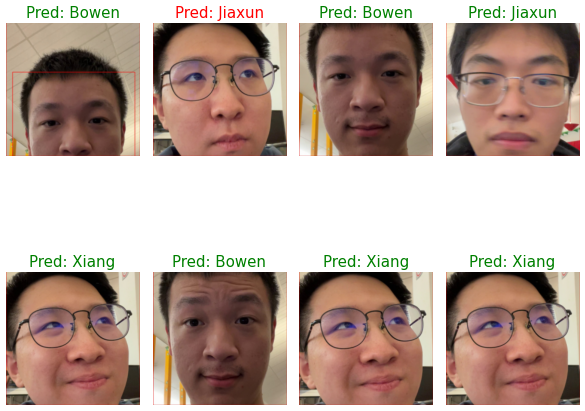

In [147]:
model.eval()
start_time = time.time()

with torch.no_grad():

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        plot_images(inputs, labels, preds, 2, 4)


### Generate adversarial image and its prediction:

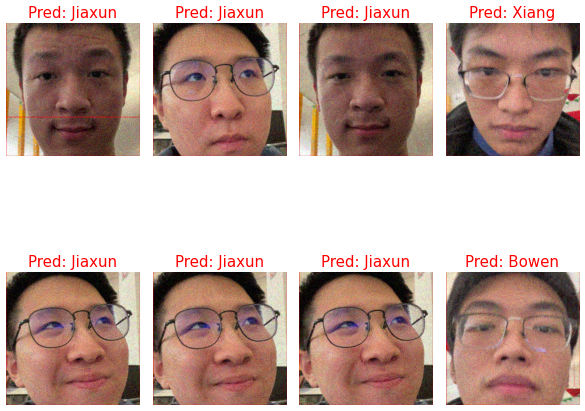

In [148]:

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    delta = pgd(model, inputs, labels, epsilon=0.1, alpha=0.01, num_iter=5)
    inputs = inputs + delta
        
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    plot_images(inputs, labels, preds, 2, 4)